In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [3]:
!pip install -q tf-models-official

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 42.7 MB/s 
     |████████████████████████████████| 1.2 MB 34.5 MB/s 
     |████████████████████████████████| 352 kB 47.1 MB/s 
     |████████████████████████████████| 99 kB 9.5 MB/s 
     |████████████████████████████████| 90 kB 9.9 MB/s 
     |████████████████████████████████| 1.1 MB 37.0 MB/s 
     |████████████████████████████████| 47.7 MB 1.6 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 213 kB 42.7 MB/s 


In [4]:
!pip install tensorflow_hub

In [5]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

sns.set_style("whitegrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/Research Paper - Emotion detection/Code Mixed Hindi-English tweets.xlsx')
pd.set_option('display.max_colwidth', None)
df.drop(['id'],axis=1, inplace=True)
df

,tweets,labels
0,aaj ka khel khatam hone k baad england cricket k youtube channel par mil jayegi,0
1,purana manjan bech rha hai,5
2,tumhare disappointed se kuch ni hoga,0
3,inse bas tiktok banva lo batting ni hoti isse cricket,3
4,bhai cricket par tweets mat kara karo please jab bhi karte ho lanka lag jaati hai this makes me angry,3
...,...,...
9160,gujarati fraud kyu hotey hai? pnbscam,3
9161,saala idhar 7 lakh k car loan k liye bank chooos leti hai aur waha log crores ka fraud karte hai bada socho niravmodi pnbfraud,3
9162,mitron nirav modi ji ka relation india k kaun se rich industrialist parivaar se hai ? batao zara ? pnbfraud,3
9163,or yahn ek month k education loan ki emi pay ni karo to call aa jata hai pnbfraud so sad,2


# Labels are as follows:
label '1' ---> racist/sexist tweet           
label '0' ---> not racist/sexist tweet

In [ ]:
print("Dataset shape: ", df.shape)
df['labels'].value_counts()

Dataset shape:  (9165, 3)


0    1892
3    1763
2    1529
1    1226
5    1147
6    1049
4     559
Name: labels, dtype: int64

# 1. Model without removing any feature:

### Splitting data into Train and Test sets

In [ ]:
X = df['tweets'] 
y = df['labels'] 
data_train, data_test = train_test_split(df, test_size=0.2, random_state=3)
X_train = data_train['tweets'].values
X_test = data_test['tweets'].values
y_train = data_train['labels'].values
y_test = data_test['labels'].values

35


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


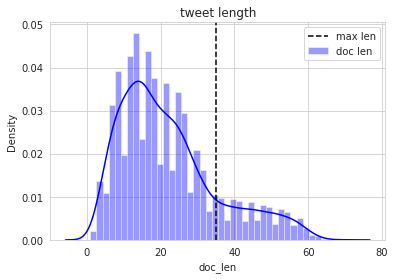

In [ ]:
# Plotting document length:
data_train['doc_len'] = data_train['tweets'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data_train['doc_len'].mean() + data_train['doc_len'].std()).astype(int)
print(max_seq_len)
sns.distplot(data_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

# BERT 
### Base Model with Neural Networks:

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Checking array created using BERT:
def get_sentence_embedding(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embedding(["You are noob.","What are you looking at?"])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8289362 , -0.45688584, -0.8976541 , ..., -0.7467428 ,
        -0.7143418 ,  0.8724918 ],
       [-0.94614434, -0.4735579 , -0.9387805 , ..., -0.735699  ,
        -0.75932556,  0.95115906]], dtype=float32)>

In [ ]:
# Bert layers:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers:
l = tf.keras.layers.Dropout(0.2, name='dropout')(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='softmax', name='output')(l)

# Construct final model:
model = tf.keras.Model(inputs=[text_input], outputs=[l])

model.summary()

METRICS = [
           tf.keras.metrics.CategoricalCrossentropy(name='accuracy'),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall')
]
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=METRICS)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

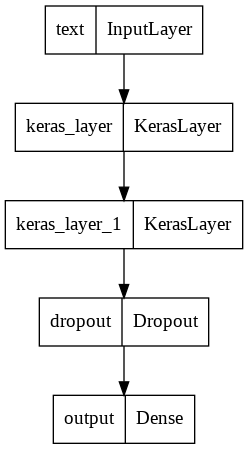

In [ ]:
#Ploting Model Architecture:
tf.keras.utils.plot_model(model)

### Training model:

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
230/230 [==============================] - 165s 663ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 2/3
230/230 [==============================] - 153s 664ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 3/3
58/58 [==============================] - 40s 657ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.8031 - recall: 1.0000


[0.0, 0.0, 0.8030551075935364, 1.0]

### Results:

In [ ]:
y_test_arg=y_test
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[361   0   0   0   0   0   0]
 [242   0   0   0   0   0   0]
 [310   0   0   0   0   0   0]
 [346   0   0   0   0   0   0]
 [104   0   0   0   0   0   0]
 [239   0   0   0   0   0   0]
 [231   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       361
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00       346
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00       231

    accuracy                           0.20      1833
   macro avg       0.03      0.14      0.05      1833
weighted avg       0.04      0.20      0.06      1833



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 2. Model after removing stopwords:

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/Research Paper - Emotion detection/Code Mixed Hindi-English tweets.xlsx')

### Removing Stopwords:

In [ ]:
# Using Hinglish stopwords which contains 1036 words from both English and Hindi languages
# Source: https://github.com/TrigonaMinima/HinglishNLP/blob/master/data/assets/stop_hinglish

stopwordlist = ['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa', 'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna', 'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as', 'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut', 'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane', 'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola', 'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye', 'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could', 'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe', 'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya', 'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono', 'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during', 'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight', 'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few', 'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four', 'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari', 'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven', 'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself', 'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge', 'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however', 'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye', 'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe', 'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into', 'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt', "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno', 'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha', 'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi', 'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski', 'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka', 'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte', 'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen', 'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu', 'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh', 'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko', 'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne', 'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon', 'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu', 'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least', 'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little', 'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga', 'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly', 'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein', 'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe', 'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't", 'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near', 'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps', 'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri', 'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi', 'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte', 'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi', 'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath', 'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt', "shouldn't", "should've", 'si', 'since', 'six', 'so', 'soch', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah', 'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th', 'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi', 'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru', 'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune', 'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa', 'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss', 'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa', 'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala', 'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin', 'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt', "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent', "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing', 'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn', 'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye', 'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'yup']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweets'] = df['tweets'].apply(lambda text: cleaning_stopwords(text))

### Splitting data into Train and Test sets

In [ ]:
X = df['tweets'] 
y = df['labels'] 
data_train, data_test = train_test_split(df, test_size=0.2, random_state=3)
X_train = data_train['tweets'].values
X_test = data_test['tweets'].values
y_train = data_train['labels'].values
y_test = data_test['labels'].values

18


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


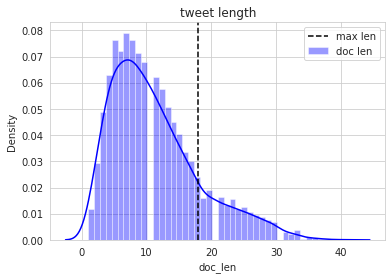

In [ ]:
# Plotting document length:
data_train['doc_len'] = data_train['tweets'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data_train['doc_len'].mean() + data_train['doc_len'].std()).astype(int)
print(max_seq_len)
sns.distplot(data_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

### Training model:

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
230/230 [==============================] - 152s 661ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 2/3
230/230 [==============================] - 152s 660ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 3/3
58/58 [==============================] - 38s 653ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.8031 - recall: 1.0000


[0.0, 0.0, 0.8030551075935364, 1.0]

### Results:

In [ ]:
y_test_arg=y_test
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[361   0   0   0   0   0   0]
 [242   0   0   0   0   0   0]
 [310   0   0   0   0   0   0]
 [346   0   0   0   0   0   0]
 [104   0   0   0   0   0   0]
 [239   0   0   0   0   0   0]
 [231   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       361
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00       346
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00       231

    accuracy                           0.20      1833
   macro avg       0.03      0.14      0.05      1833
weighted avg       0.04      0.20      0.06      1833



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 3. Model after removing repeating characters:

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/Research Paper - Emotion detection/Code Mixed Hindi-English tweets.xlsx')

### Removing repeating characteres:

In [ ]:
tokens = (word_tokenize(i) for i in df.tweets)
df['tweets'] = df['tweets'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.tweets = df.tweets.apply(lambda tweet: reduce_sequence_tweet(tweet))

# Detokenizing tweets:

def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

df['tweets'] = df['tweets'].apply(lambda x: listToString(x))

### Splitting data into Train and Test sets

In [ ]:
X = df['tweets']  
y = df['labels'] 
data_train, data_test = train_test_split(df, test_size=0.2, random_state=3)
X_train = data_train['tweets'].values
X_test = data_test['tweets'].values
y_train = data_train['labels'].values
y_test = data_test['labels'].values

35


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


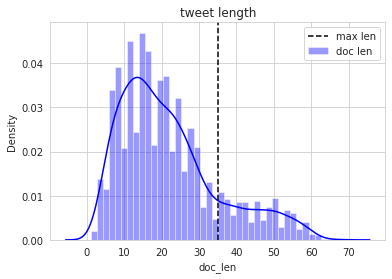

In [ ]:
# Plotting document length:
data_train['doc_len'] = data_train['tweets'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data_train['doc_len'].mean() + data_train['doc_len'].std()).astype(int)
print(max_seq_len)
sns.distplot(data_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

### Training model:

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
230/230 [==============================] - 152s 660ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 2/3
230/230 [==============================] - 152s 660ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 3/3
58/58 [==============================] - 38s 654ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.8031 - recall: 1.0000


[0.0, 0.0, 0.8030551075935364, 1.0]

### Results:

In [ ]:
y_test_arg=y_test
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[361   0   0   0   0   0   0]
 [242   0   0   0   0   0   0]
 [310   0   0   0   0   0   0]
 [346   0   0   0   0   0   0]
 [104   0   0   0   0   0   0]
 [239   0   0   0   0   0   0]
 [231   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       361
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00       346
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00       231

    accuracy                           0.20      1833
   macro avg       0.03      0.14      0.05      1833
weighted avg       0.04      0.20      0.06      1833



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 4. Model after removing Punctuations:

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/Research Paper - Emotion detection/Code Mixed Hindi-English tweets.xlsx')

### Removing Punctuations:

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['tweets'] = df['tweets'].apply(lambda x: cleaning_punctuations(x))

### Splitting data into Train and Test sets

In [ ]:
X = df['tweets']  
y = df['labels'] 
data_train, data_test = train_test_split(df, test_size=0.2, random_state=3)
X_train = data_train['tweets'].values
X_test = data_test['tweets'].values
y_train = data_train['labels'].values
y_test = data_test['labels'].values

35


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


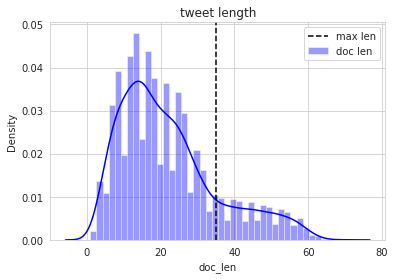

In [ ]:
# Plotting document length:
data_train['doc_len'] = data_train['tweets'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data_train['doc_len'].mean() + data_train['doc_len'].std()).astype(int)
print(max_seq_len)
sns.distplot(data_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

### Training model:

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
230/230 [==============================] - 152s 659ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 2/3
230/230 [==============================] - 152s 659ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 3/3
58/58 [==============================] - 38s 653ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.8031 - recall: 1.0000


[0.0, 0.0, 0.8030551075935364, 1.0]

### Results:

In [ ]:
y_test_arg=y_test
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[361   0   0   0   0   0   0]
 [242   0   0   0   0   0   0]
 [310   0   0   0   0   0   0]
 [346   0   0   0   0   0   0]
 [104   0   0   0   0   0   0]
 [239   0   0   0   0   0   0]
 [231   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       361
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00       346
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00       231

    accuracy                           0.20      1833
   macro avg       0.03      0.14      0.05      1833
weighted avg       0.04      0.20      0.06      1833



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 5. Model after removing numbers:

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/Research Paper - Emotion detection/Code Mixed Hindi-English tweets.xlsx')

### Removing numbers:

In [ ]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['tweets'] = df['tweets'].apply(lambda text: cleaning_numbers(text))

### Splitting data into Train and Test sets

In [ ]:
X = df['tweets']  
y = df['labels'] 
data_train, data_test = train_test_split(df, test_size=0.2, random_state=3)
X_train = data_train['tweets'].values
X_test = data_test['tweets'].values
y_train = data_train['labels'].values
y_test = data_test['labels'].values

35


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


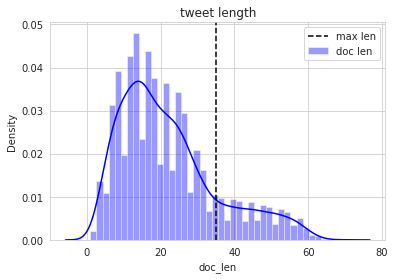

In [ ]:
# Plotting document length:
data_train['doc_len'] = data_train['tweets'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data_train['doc_len'].mean() + data_train['doc_len'].std()).astype(int)
print(max_seq_len)
sns.distplot(data_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

### Training model:

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
230/230 [==============================] - 152s 659ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 2/3
230/230 [==============================] - 152s 662ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 3/3
58/58 [==============================] - 38s 656ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.8031 - recall: 1.0000


[0.0, 0.0, 0.8030551075935364, 1.0]

### Results:

In [ ]:
y_test_arg=y_test
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[361   0   0   0   0   0   0]
 [242   0   0   0   0   0   0]
 [310   0   0   0   0   0   0]
 [346   0   0   0   0   0   0]
 [104   0   0   0   0   0   0]
 [239   0   0   0   0   0   0]
 [231   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       361
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00       346
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00       231

    accuracy                           0.20      1833
   macro avg       0.03      0.14      0.05      1833
weighted avg       0.04      0.20      0.06      1833



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 6. Models after removing all the features:

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Datasets/Research Paper - Emotion detection/Code Mixed Hindi-English tweets.xlsx')

### Removing Punctuations:

In [ ]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
punctuations_list = string.punctuation
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

df['tweets'] = df['tweets'].apply(lambda x: cleaning_punctuations(x))

### Removing Stopwords:

In [ ]:
# Using Hinglish stopwords which contains 1036 words from both English and Hindi languages
# Source: https://github.com/TrigonaMinima/HinglishNLP/blob/master/data/assets/stop_hinglish

stopwordlist = ['a', 'aadi', 'aaj', 'aap', 'aapne', 'aata', 'aati', 'aaya', 'aaye', 'ab', 'abbe', 'abbey', 'abe', 'abhi', 'able', 'about', 'above', 'accha', 'according', 'accordingly', 'acha', 'achcha', 'across', 'actually', 'after', 'afterwards', 'again', 'against', 'agar', 'ain', 'aint', "ain't", 'aisa', 'aise', 'aisi', 'alag', 'all', 'allow', 'allows', 'almost', 'alone', 'along', 'already', 'also', 'although', 'always', 'am', 'among', 'amongst', 'an', 'and', 'andar', 'another', 'any', 'anybody', 'anyhow', 'anyone', 'anything', 'anyway', 'anyways', 'anywhere', 'ap', 'apan', 'apart', 'apna', 'apnaa', 'apne', 'apni', 'appear', 'are', 'aren', 'arent', "aren't", 'around', 'arre', 'as', 'aside', 'ask', 'asking', 'at', 'aur', 'avum', 'aya', 'aye', 'baad', 'baar', 'bad', 'bahut', 'bana', 'banae', 'banai', 'banao', 'banaya', 'banaye', 'banayi', 'banda', 'bande', 'bandi', 'bane', 'bani', 'bas', 'bata', 'batao', 'bc', 'be', 'became', 'because', 'become', 'becomes', 'becoming', 'been', 'before', 'beforehand', 'behind', 'being', 'below', 'beside', 'besides', 'best', 'better', 'between', 'beyond', 'bhai', 'bheetar', 'bhi', 'bhitar', 'bht', 'bilkul', 'bohot', 'bol', 'bola', 'bole', 'boli', 'bolo', 'bolta', 'bolte', 'bolti', 'both', 'brief', 'bro', 'btw', 'but', 'by', 'came', 'can', 'cannot', 'cant', "can't", 'cause', 'causes', 'certain', 'certainly', 'chahiye', 'chaiye', 'chal', 'chalega', 'chhaiye', 'clearly', "c'mon", 'com', 'come', 'comes', 'could', 'couldn', 'couldnt', "couldn't", 'd', 'de', 'dede', 'dega', 'degi', 'dekh', 'dekha', 'dekhe', 'dekhi', 'dekho', 'denge', 'dhang', 'di', 'did', 'didn', 'didnt', "didn't", 'dijiye', 'diya', 'diyaa', 'diye', 'diyo', 'do', 'does', 'doesn', 'doesnt', "doesn't", 'doing', 'done', 'dono', 'dont', "don't", 'doosra', 'doosre', 'down', 'downwards', 'dude', 'dunga', 'dungi', 'during', 'dusra', 'dusre', 'dusri', 'dvaara', 'dvara', 'dwaara', 'dwara', 'each', 'edu', 'eg', 'eight', 'either', 'ek', 'else', 'elsewhere', 'enough', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone', 'everything', 'everywhere', 'ex', 'exactly', 'example', 'except', 'far', 'few', 'fifth', 'fir', 'first', 'five', 'followed', 'following', 'follows', 'for', 'forth', 'four', 'from', 'further', 'furthermore', 'gaya', 'gaye', 'gayi', 'get', 'gets', 'getting', 'ghar', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'good', 'got', 'gotten', 'greetings', 'haan', 'had', 'hadd', 'hadn', 'hadnt', "hadn't", 'hai', 'hain', 'hamara', 'hamare', 'hamari', 'hamne', 'han', 'happens', 'har', 'hardly', 'has', 'hasn', 'hasnt', "hasn't", 'have', 'haven', 'havent', "haven't", 'having', 'he', 'hello', 'help', 'hence', 'her', 'here', 'hereafter', 'hereby', 'herein', "here's", 'hereupon', 'hers', 'herself', "he's", 'hi', 'him', 'himself', 'his', 'hither', 'hm', 'hmm', 'ho', 'hoga', 'hoge', 'hogi', 'hona', 'honaa', 'hone', 'honge', 'hongi', 'honi', 'hopefully', 'hota', 'hotaa', 'hote', 'hoti', 'how', 'howbeit', 'however', 'hoyenge', 'hoyengi', 'hu', 'hua', 'hue', 'huh', 'hui', 'hum', 'humein', 'humne', 'hun', 'huye', 'huyi', 'i', "i'd", 'idk', 'ie', 'if', "i'll", "i'm", 'imo', 'in', 'inasmuch', 'inc', 'inhe', 'inhi', 'inho', 'inka', 'inkaa', 'inke', 'inki', 'inn', 'inner', 'inse', 'insofar', 'into', 'inward', 'is', 'ise', 'isi', 'iska', 'iskaa', 'iske', 'iski', 'isme', 'isn', 'isne', 'isnt', "isn't", 'iss', 'isse', 'issi', 'isski', 'it', "it'd", "it'll", 'itna', 'itne', 'itni', 'itno', 'its', "it's", 'itself', 'ityaadi', 'ityadi', "i've", 'ja', 'jaa', 'jab', 'jabh', 'jaha', 'jahaan', 'jahan', 'jaisa', 'jaise', 'jaisi', 'jata', 'jayega', 'jidhar', 'jin', 'jinhe', 'jinhi', 'jinho', 'jinhone', 'jinka', 'jinke', 'jinki', 'jinn', 'jis', 'jise', 'jiska', 'jiske', 'jiski', 'jisme', 'jiss', 'jisse', 'jitna', 'jitne', 'jitni', 'jo', 'just', 'jyaada', 'jyada', 'k', 'ka', 'kaafi', 'kab', 'kabhi', 'kafi', 'kaha', 'kahaa', 'kahaan', 'kahan', 'kahi', 'kahin', 'kahte', 'kaisa', 'kaise', 'kaisi', 'kal', 'kam', 'kar', 'kara', 'kare', 'karega', 'karegi', 'karen', 'karenge', 'kari', 'karke', 'karna', 'karne', 'karni', 'karo', 'karta', 'karte', 'karti', 'karu', 'karun', 'karunga', 'karungi', 'kaun', 'kaunsa', 'kayi', 'kch', 'ke', 'keep', 'keeps', 'keh', 'kehte', 'kept', 'khud', 'ki', 'kin', 'kine', 'kinhe', 'kinho', 'kinka', 'kinke', 'kinki', 'kinko', 'kinn', 'kino', 'kis', 'kise', 'kisi', 'kiska', 'kiske', 'kiski', 'kisko', 'kisliye', 'kisne', 'kitna', 'kitne', 'kitni', 'kitno', 'kiya', 'kiye', 'know', 'known', 'knows', 'ko', 'koi', 'kon', 'konsa', 'koyi', 'krna', 'krne', 'kuch', 'kuchch', 'kuchh', 'kul', 'kull', 'kya', 'kyaa', 'kyu', 'kyuki', 'kyun', 'kyunki', 'lagta', 'lagte', 'lagti', 'last', 'lately', 'later', 'le', 'least', 'lekar', 'lekin', 'less', 'lest', 'let', "let's", 'li', 'like', 'liked', 'likely', 'little', 'liya', 'liye', 'll', 'lo', 'log', 'logon', 'lol', 'look', 'looking', 'looks', 'ltd', 'lunga', 'm', 'maan', 'maana', 'maane', 'maani', 'maano', 'magar', 'mai', 'main', 'maine', 'mainly', 'mana', 'mane', 'mani', 'mano', 'many', 'mat', 'may', 'maybe', 'me', 'mean', 'meanwhile', 'mein', 'mera', 'mere', 'merely', 'meri', 'might', 'mightn', 'mightnt', "mightn't", 'mil', 'mjhe', 'more', 'moreover', 'most', 'mostly', 'much', 'mujhe', 'must', 'mustn', 'mustnt', "mustn't", 'my', 'myself', 'na', 'naa', 'naah', 'nahi', 'nahin', 'nai', 'name', 'namely', 'nd', 'ne', 'near', 'nearly', 'necessary', 'neeche', 'need', 'needn', 'neednt', "needn't", 'needs', 'neither', 'never', 'nevertheless', 'new', 'next', 'nhi', 'nine', 'no', 'nobody', 'non', 'none', 'noone', 'nope', 'nor', 'normally', 'not', 'nothing', 'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often', 'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only', 'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our', 'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own', 'par', 'pata', 'pe', 'pehla', 'pehle', 'pehli', 'people', 'per', 'perhaps', 'phla', 'phle', 'phli', 'placed', 'please', 'plus', 'poora', 'poori', 'provides', 'pura', 'puri', 'q', 'que', 'quite', 'raha', 'rahaa', 'rahe', 'rahi', 'rakh', 'rakha', 'rakhe', 'rakhen', 'rakhi', 'rakho', 'rather', 're', 'really', 'reasonably', 'regarding', 'regardless', 'regards', 'rehte', 'rha', 'rhaa', 'rhe', 'rhi', 'ri', 'right', 's', 'sa', 'saara', 'saare', 'saath', 'sab', 'sabhi', 'sabse', 'sahi', 'said', 'sakta', 'saktaa', 'sakte', 'sakti', 'same', 'sang', 'sara', 'sath', 'saw', 'say', 'saying', 'says', 'se', 'second', 'secondly', 'see', 'seeing', 'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves', 'sensible', 'sent', 'serious', 'seriously', 'seven', 'several', 'shall', 'shan', 'shant', "shan't", 'she', "she's", 'should', 'shouldn', 'shouldnt', "shouldn't", "should've", 'si', 'since', 'six', 'so', 'soch', 'some', 'somebody', 'somehow', 'someone', 'something', 'sometime', 'sometimes', 'somewhat', 'somewhere', 'soon', 'still', 'sub', 'such', 'sup', 'sure', 't', 'tab', 'tabh', 'tak', 'take', 'taken', 'tarah', 'teen', 'teeno', 'teesra', 'teesre', 'teesri', 'tell', 'tends', 'tera', 'tere', 'teri', 'th', 'tha', 'than', 'thank', 'thanks', 'thanx', 'that', "that'll", 'thats', "that's", 'the', 'theek', 'their', 'theirs', 'them', 'themselves', 'then', 'thence', 'there', 'thereafter', 'thereby', 'therefore', 'therein', 'theres', "there's", 'thereupon', 'these', 'they', "they'd", "they'll", "they're", "they've", 'thi', 'thik', 'thing', 'think', 'thinking', 'third', 'this', 'tho', 'thoda', 'thodi', 'thorough', 'thoroughly', 'those', 'though', 'thought', 'three', 'through', 'throughout', 'thru', 'thus', 'tjhe', 'to', 'together', 'toh', 'too', 'took', 'toward', 'towards', 'tried', 'tries', 'true', 'truly', 'try', 'trying', 'tu', 'tujhe', 'tum', 'tumhara', 'tumhare', 'tumhari', 'tune', 'twice', 'two', 'um', 'umm', 'un', 'under', 'unhe', 'unhi', 'unho', 'unhone', 'unka', 'unkaa', 'unke', 'unki', 'unko', 'unless', 'unlikely', 'unn', 'unse', 'until', 'unto', 'up', 'upar', 'upon', 'us', 'use', 'used', 'useful', 'uses', 'usi', 'using', 'uska', 'uske', 'usne', 'uss', 'usse', 'ussi', 'usually', 'vaala', 'vaale', 'vaali', 'vahaan', 'vahan', 'vahi', 'vahin', 'vaisa', 'vaise', 'vaisi', 'vala', 'vale', 'vali', 'various', 've', 'very', 'via', 'viz', 'vo', 'waala', 'waale', 'waali', 'wagaira', 'wagairah', 'wagerah', 'waha', 'wahaan', 'wahan', 'wahi', 'wahin', 'waisa', 'waise', 'waisi', 'wala', 'wale', 'wali', 'want', 'wants', 'was', 'wasn', 'wasnt', "wasn't", 'way', 'we', "we'd", 'well', "we'll", 'went', 'were', "we're", 'weren', 'werent', "weren't", "we've", 'what', 'whatever', "what's", 'when', 'whence', 'whenever', 'where', 'whereafter', 'whereas', 'whereby', 'wherein', "where's", 'whereupon', 'wherever', 'whether', 'which', 'while', 'who', 'whoever', 'whole', 'whom', "who's", 'whose', 'why', 'will', 'willing', 'with', 'within', 'without', 'wo', 'woh', 'wohi', 'won', 'wont', "won't", 'would', 'wouldn', 'wouldnt', "wouldn't", 'y', 'ya', 'yadi', 'yah', 'yaha', 'yahaan', 'yahan', 'yahi', 'yahin', 'ye', 'yeah', 'yeh', 'yehi', 'yes', 'yet', 'you', "you'd", "you'll", 'your', "you're", 'yours', 'yourself', 'yourselves', "you've", 'yup']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

df['tweets'] = df['tweets'].apply(lambda text: cleaning_stopwords(text))

### Removing Numbers:

In [ ]:
def cleaning_numbers(text):
    return re.sub('[0-9]+', '', text)

df['tweets'] = df['tweets'].apply(lambda text: cleaning_numbers(text))

### Removing repeating characters:

In [ ]:
tokens = (word_tokenize(i) for i in df.tweets)
df['tweets'] = df['tweets'].apply(nltk.word_tokenize)

pattern = re.compile(r'(.)\1*')

def reduce_sequence_word(word):
    return ''.join([match.group()[:2] if len(match.group()) > 2 else match.group() for match in pattern.finditer(word)])

def reduce_sequence_tweet(tweet):
    return [reduce_sequence_word(word) for word in tweet]

df.tweets = df.tweets.apply(lambda tweet: reduce_sequence_tweet(tweet))

# Detokenizing tweets:

def listToString(s): 
    
    # initialize an empty string
    str1 = " " 
    
    # return string  
    return (str1.join(s))

df['tweets'] = df['tweets'].apply(lambda x: listToString(x))

### Splitting data into Train and Test sets

In [ ]:
X = df['tweets'] 
y = df['labels'] 
data_train, data_test = train_test_split(df, test_size=0.2, random_state=3)
X_train = data_train['tweets'].values
X_test = data_test['tweets'].values
y_train = data_train['labels'].values
y_test = data_test['labels'].values

18


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


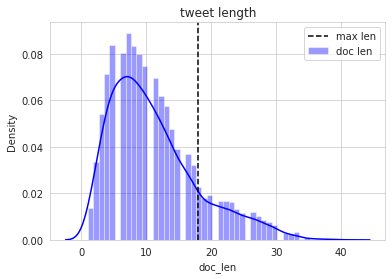

In [ ]:
# Plotting document length:
data_train['doc_len'] = data_train['tweets'].astype(str).apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(data_train['doc_len'].mean() + data_train['doc_len'].std()).astype(int)
print(max_seq_len)
sns.distplot(data_train['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('tweet length'); 
plt.legend()
plt.show()

### Training model:

In [ ]:
history = model.fit(X_train, y_train, epochs=3)

# Evaluating results with test set:
model.evaluate(X_test, y_test, verbose=1)

Epoch 1/3
230/230 [==============================] - 152s 659ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 2/3
230/230 [==============================] - 152s 661ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.7912 - recall: 1.0000
Epoch 3/3
58/58 [==============================] - 38s 656ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - precision: 0.8031 - recall: 1.0000


[0.0, 0.0, 0.8030551075935364, 1.0]

### Results:

In [ ]:
y_test_arg=y_test
y_pred = np.argmax(model.predict(X_test),axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test_arg, y_pred))
print(metrics.classification_report(y_test_arg, y_pred))

Confusion Matrix
[[361   0   0   0   0   0   0]
 [242   0   0   0   0   0   0]
 [310   0   0   0   0   0   0]
 [346   0   0   0   0   0   0]
 [104   0   0   0   0   0   0]
 [239   0   0   0   0   0   0]
 [231   0   0   0   0   0   0]]
              precision    recall  f1-score   support

           0       0.20      1.00      0.33       361
           1       0.00      0.00      0.00       242
           2       0.00      0.00      0.00       310
           3       0.00      0.00      0.00       346
           4       0.00      0.00      0.00       104
           5       0.00      0.00      0.00       239
           6       0.00      0.00      0.00       231

    accuracy                           0.20      1833
   macro avg       0.03      0.14      0.05      1833
weighted avg       0.04      0.20      0.06      1833



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
